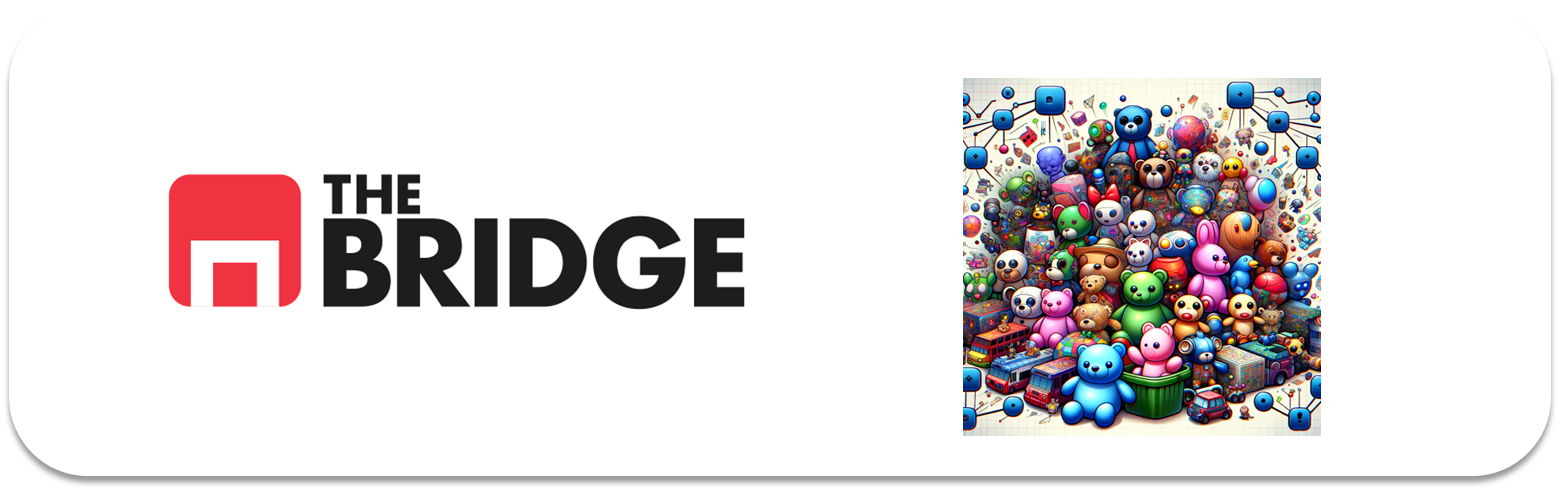

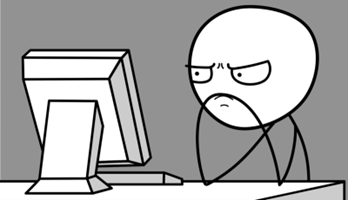

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitar√°s datos que est√°n en el directorio data que acompa√±a al notebook (b√∫scalo en el repositorio de ejercicios)
  
La soluci√≥n a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

In [3]:
!pip install yellowbrick

In [17]:
# üìå Importaci√≥n de librer√≠as necesarias
import pandas as pd  # Manipulaci√≥n de datos
import numpy as np  # Operaciones num√©ricas
import matplotlib.pyplot as plt  # Visualizaci√≥n
import seaborn as sns  # Visualizaci√≥n avanzada
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Preprocesamiento de datos
from sklearn.cluster import KMeans  # Algoritmo de clustering K-Means
from sklearn.metrics import silhouette_score  # Evaluaci√≥n del clustering
from scipy.spatial.distance import cdist  # C√°lculo de distancias
from scipy.cluster.hierarchy import dendrogram, linkage  # Clustering jer√°rquico
from sklearn.decomposition import PCA  # Reducci√≥n de dimensionalidad
from sklearn.manifold import TSNE  # Reducci√≥n de dimensionalidad no lineal
from yellowbrick.cluster import KElbowVisualizer  # Visualizaci√≥n del m√©todo del codo

# Configuraci√≥n de visualizaci√≥n
sns.set(style="whitegrid")  # Estilo de gr√°ficos
plt.rcParams["figure.figsize"] = (10, 6)  # Tama√±o de gr√°ficos por defecto

print("üìå Todas las librer√≠as han sido importadas correctamente.")


üìå Todas las librer√≠as han sido importadas correctamente.


### Entendiendo el problema de negocio

En este notebook vamos a hacer un an√°lisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos informaci√≥n como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes f√°rmacos, sus efectos y ratings de los clientes de dichos f√°rmacos. Realiza una inspecci√≥n preliminar y quita las columnas que consideres innecesarias.

In [ ]:
import pandas as pd

# Ruta del archivo (corrige la ruta si es necesario)
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"

# Cargar el archivo TSV con tabulaciones como separador
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# Inspecci√≥n preliminar
print("üîç Primeras filas del dataset:")
print(df.head())



üîç Primeras filas del dataset:
   Unnamed: 0       urlDrugName  rating         effectiveness  \
0        2202         enalapril       4      Highly Effective   
1        3117  ortho-tri-cyclen       1      Highly Effective   
2        1146           ponstel      10      Highly Effective   
3        3947          prilosec       3  Marginally Effective   
4        1951            lyrica       2  Marginally Effective   

           sideEffects                               condition  \
0    Mild Side Effects  management of congestive heart failure   
1  Severe Side Effects                        birth prevention   
2      No Side Effects                        menstrual cramps   
3    Mild Side Effects                             acid reflux   
4  Severe Side Effects                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was us

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qu√© variables son descartables en funci√≥n de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificaci√≥n, descarta la columna con url.

In [60]:


# Cargar el dataset desde la ruta correcta
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# üîç Inspecci√≥n preliminar de las columnas
print("üìå Nombres de las columnas del dataset:")
print(df.columns)

# üìä Calcular la cardinalidad de cada columna
cardinalidad = df.nunique()
total_filas = df.shape[0]

# üìâ Calcular el porcentaje de cardinalidad
porcentaje_cardinalidad = (cardinalidad / total_filas) * 100

# üìä Crear un DataFrame con la informaci√≥n de cardinalidad
df_cardinalidad = pd.DataFrame({
    "Columna": df.columns,
    "Cardinalidad": cardinalidad.values,
    "Porcentaje": porcentaje_cardinalidad.values
}).sort_values(by="Porcentaje", ascending=False)

# üìå Mostrar la tabla con la cardinalidad
print("\nüìä Cardinalidad de las variables:")
print(df_cardinalidad)

# üöÄ Filtrar columnas a eliminar
columnas_a_descartar = df_cardinalidad[df_cardinalidad["Porcentaje"] > 80]["Columna"].tolist()  # Umbral del 80%
columnas_a_descartar.append("urlDrugName")  # Eliminamos la URL por simplificaci√≥n

print(f"\nüõë Columnas eliminadas: {columnas_a_descartar}")

# üéØ Crear un nuevo dataset sin estas columnas
df_filtrado = df.drop(columns=columnas_a_descartar, errors="ignore")

# üîç Mostrar primeras filas del dataset filtrado
print("\n‚úÖ Dataset despu√©s de la limpieza:")
print(df_filtrado.head())

# Guardar el dataset limpio para los siguientes ejercicios
df_filtrado.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.csv", index=False)



üìå Nombres de las columnas del dataset:
Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')

üìä Cardinalidad de las variables:
             Columna  Cardinalidad  Porcentaje
0         Unnamed: 0          3107  100.000000
8     commentsReview          3046   98.036691
6     benefitsReview          3031   97.553911
7  sideEffectsReview          2813   90.537496
5          condition          1426   45.896363
1        urlDrugName           502   16.157065
2             rating            10    0.321854
3      effectiveness             5    0.160927
4        sideEffects             5    0.160927

üõë Columnas eliminadas: ['Unnamed: 0', 'commentsReview', 'benefitsReview', 'sideEffectsReview', 'urlDrugName']

‚úÖ Dataset despu√©s de la limpieza:
   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1

### Ejercicio 3

Construye un train set (ll√°malo X) s√≥lo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [57]:
# Definir las columnas seleccionadas (features que NO fueron descartadas)
columnas_seleccionadas = df_filtrado.columns.tolist()

# Crear el dataset de entrenamiento (X)
X = df_filtrado[columnas_seleccionadas].copy()

# üìå Mostrar informaci√≥n del nuevo dataset de entrenamiento
print("‚úÖ Train set creado correctamente.")
print(f"üìä Dimensiones de X: {X.shape}")
print(f"üìå Columnas seleccionadas en X: {columnas_seleccionadas}")

# Mostrar las primeras filas del dataset
print("\nüîç Primeras filas de X:")
print(X.head())

# Guardar X para uso futuro
X.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_features.csv", index=False)


‚úÖ Train set creado correctamente.
üìä Dimensiones de X: (3107, 5)
üìå Columnas seleccionadas en X: ['rating', 'effectiveness', 'sideEffects', 'condition', 'Cluster']

üîç Primeras filas de X:
   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1      Highly Effective  Severe Side Effects   
2      10      Highly Effective      No Side Effects   
3       3  Marginally Effective    Mild Side Effects   
4       2  Marginally Effective  Severe Side Effects   

                                condition  Cluster  
0  management of congestive heart failure        2  
1                        birth prevention        2  
2                        menstrual cramps        0  
3                             acid reflux        2  
4                            fibromyalgia        2  


### Ejercicio 4 

Trasforma las features que consideres necesario (categ√≥ricas y num√©ricas) y luego aplica el escalado que consideres necesario.

In [58]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# üìå Identificar columnas categ√≥ricas y num√©ricas
columnas_categoricas = X.select_dtypes(include=["object"]).columns.tolist()
columnas_numericas = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"üìå Columnas categ√≥ricas: {columnas_categoricas}")
print(f"üìå Columnas num√©ricas: {columnas_numericas}")

# üîπ Definir transformaciones para cada tipo de dato
transformaciones = ColumnTransformer([
    ("num_scaler", StandardScaler(), columnas_numericas),  # Escalado de num√©ricas
    ("cat_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), columnas_categoricas)  # Codificaci√≥n de categ√≥ricas
])

# üìå Crear un pipeline de preprocesamiento
pipeline = Pipeline([
    ("transformaciones", transformaciones)
])

# üöÄ Aplicar el pipeline al dataset
X_transformado = pipeline.fit_transform(X)

# üìå Convertir a DataFrame manteniendo nombres de columnas
columnas_codificadas = pipeline.named_steps["transformaciones"].named_transformers_["cat_encoder"].get_feature_names_out(columnas_categoricas)
columnas_finales = columnas_numericas + list(columnas_codificadas)
X_procesado = pd.DataFrame(X_transformado, columns=columnas_finales)

# üìä Mostrar informaci√≥n del nuevo dataset procesado
print("‚úÖ Transformaci√≥n completada.")
print(f"üìä Dimensiones de X procesado: {X_procesado.shape}")
print("\nüîç Primeras filas de X despu√©s de transformaci√≥n:")
print(X_procesado.head())

# üìÅ Guardar el dataset transformado para siguientes ejercicios
X_procesado.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_transformed.csv", index=False)


üìå Columnas categ√≥ricas: ['effectiveness', 'sideEffects', 'condition']
üìå Columnas num√©ricas: ['rating']
‚úÖ Transformaci√≥n completada.
üìä Dimensiones de X procesado: (3107, 1438)

üîç Primeras filas de X despu√©s de transformaci√≥n:
     rating  effectiveness_Considerably Effective  \
0 -1.023494                                   0.0   
1 -2.044907                                   0.0   
2  1.019330                                   0.0   
3 -1.363965                                   0.0   
4 -1.704436                                   0.0   

   effectiveness_Highly Effective  effectiveness_Ineffective  \
0                             1.0                        0.0   
1                             1.0                        0.0   
2                             1.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   effectiveness_Marginally Effective  effectiveness

### Ejercicio 5: Otenci√≥n de K, aproximaci√≥n visual

Analiza la relaci√≥n entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente alg√∫n indicio del n√∫mero de cl√∫steres que podr√≠amos estar buscando. Por otro lado este an√°lisis nos puede hacer descartar alguna feature o generar una nueva

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


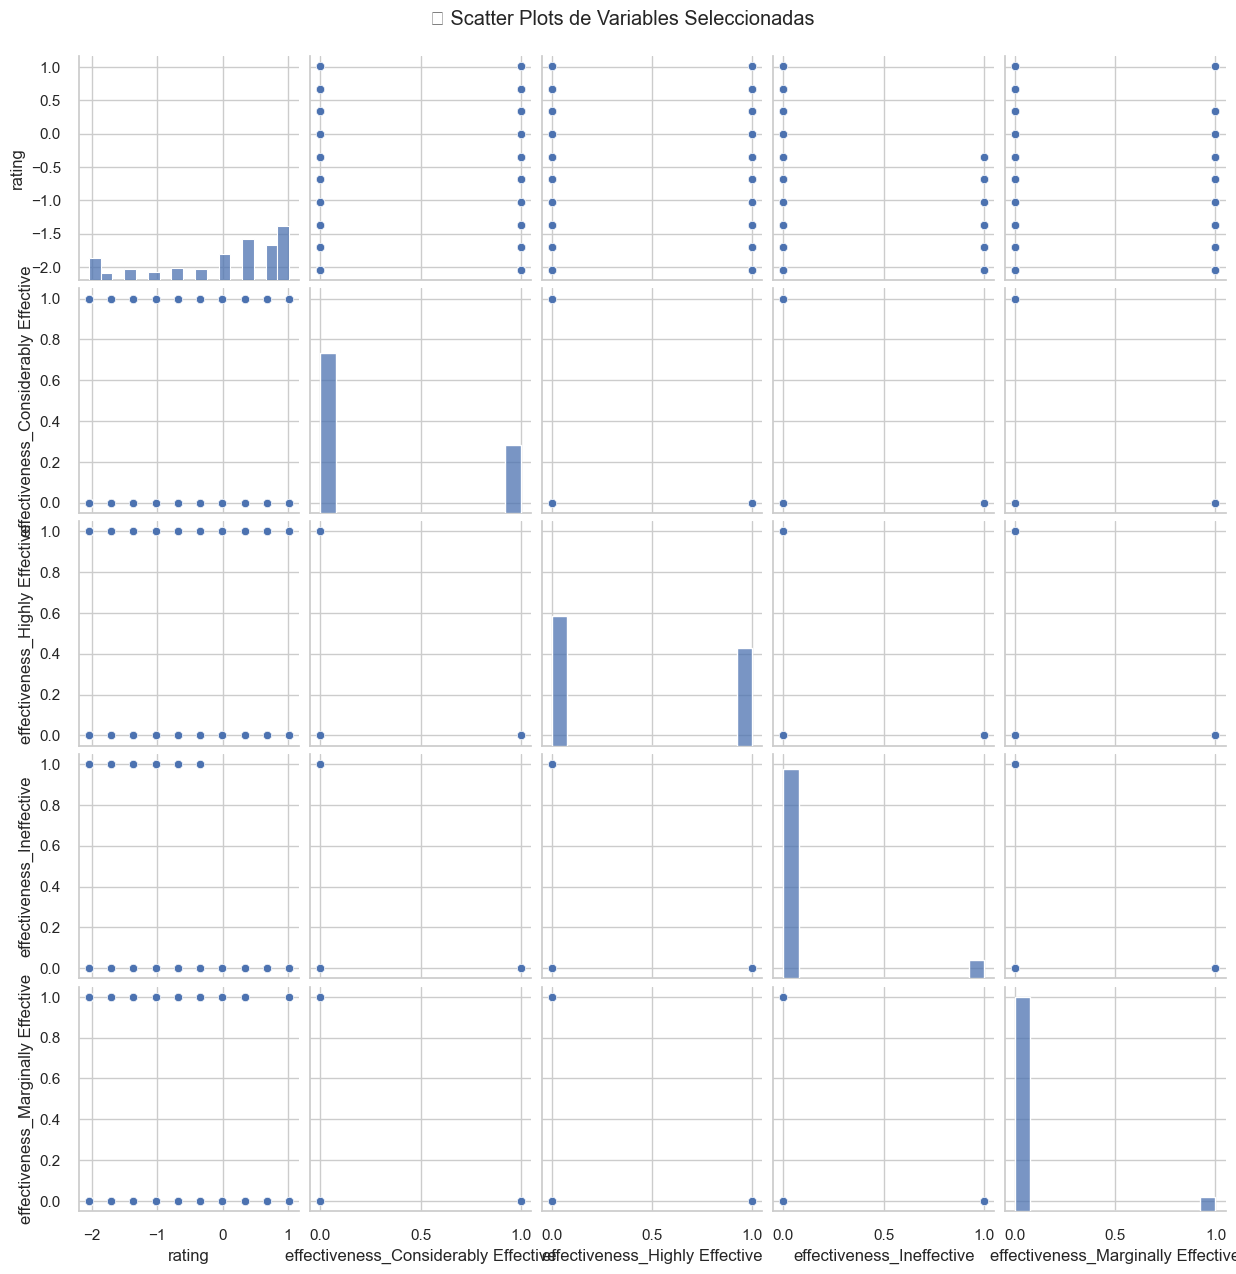

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


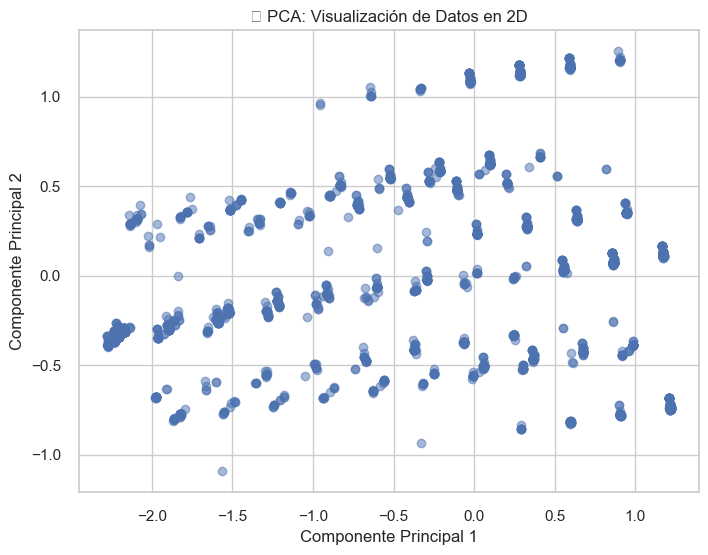

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


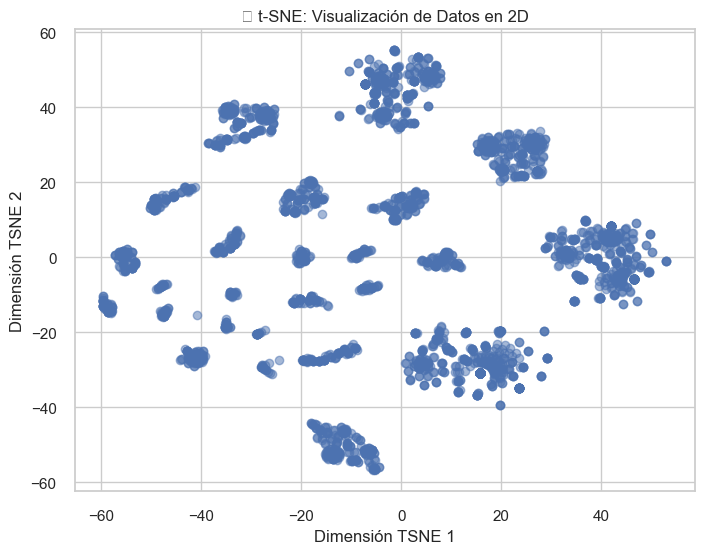

In [59]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# üîπ Selecci√≥n de features num√©ricas para an√°lisis visual
num_features = X_procesado.iloc[:, :5]  # Tomamos las primeras 5 columnas num√©ricas

# üìä Crear scatter plots de pares de variables para buscar patrones
sns.pairplot(num_features)
plt.suptitle("üîç Scatter Plots de Variables Seleccionadas", y=1.02)
plt.show()

# üöÄ **Reducci√≥n de dimensionalidad con PCA**
pca = PCA(n_components=2)  # Reducimos a 2 dimensiones
X_pca = pca.fit_transform(X_procesado)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("üîç PCA: Visualizaci√≥n de Datos en 2D")
plt.show()

# üöÄ **Reducci√≥n de dimensionalidad con t-SNE**
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_procesado)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.xlabel("Dimensi√≥n TSNE 1")
plt.ylabel("Dimensi√≥n TSNE 2")
plt.title("üîç t-SNE: Visualizaci√≥n de Datos en 2D")
plt.show()


### Ejercicio 6: Obtenci√≥n de K, m√©todo del codo

Evalua diferentes valores K y escoge uno a partir del m√©todo del codo/elbow de inercia.

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


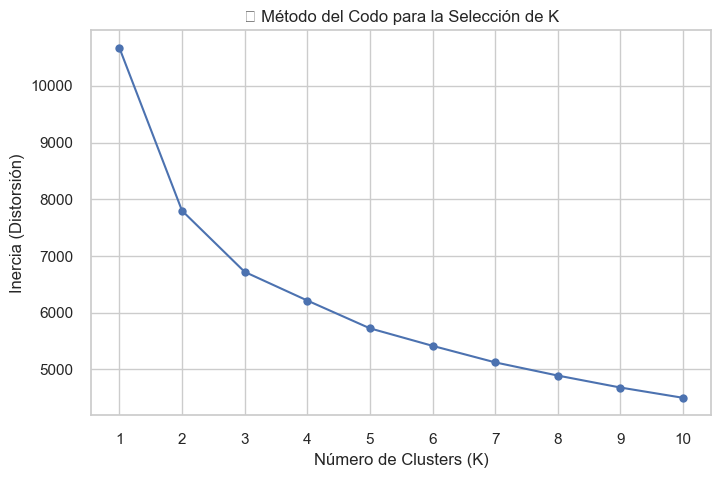

In [52]:


# üîπ Definir un rango de valores de K a probar
k_values = range(1, 11)  # Probamos K desde 1 hasta 10
inertia_values = []

# üöÄ Aplicar K-Means para cada K y calcular la inercia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_procesado)  # X_procesado es el dataset ya transformado y escalado
    inertia_values.append(kmeans.inertia_)

# üìä Graficar el m√©todo del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("N√∫mero de Clusters (K)")
plt.ylabel("Inercia (Distorsi√≥n)")
plt.title("üîç M√©todo del Codo para la Selecci√≥n de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()


### Ejercicio 7: Obtenci√≥n de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gr√°fico de la evoluci√≥n de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


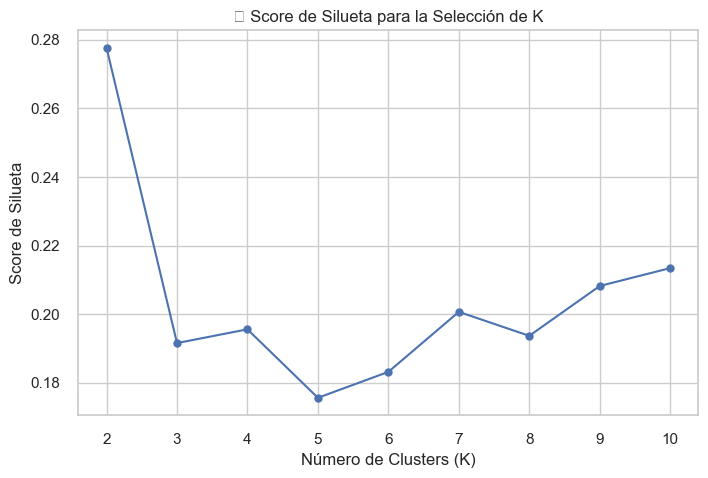

‚úÖ El mejor n√∫mero de clusters seg√∫n el score de silueta es: 2


In [51]:


# üîπ Definir el rango de K que analizamos en el m√©todo del codo
k_values = range(2, 11)  # Empezamos desde K=2 porque K=1 no tiene sentido para silueta
silhouette_scores = []

# üöÄ Aplicar K-Means y calcular el score de silueta para cada K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_procesado)  # X_procesado es el dataset transformado y escalado
    score = silhouette_score(X_procesado, cluster_labels)
    silhouette_scores.append(score)

# üìä Graficar el score de silueta para cada K
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("N√∫mero de Clusters (K)")
plt.ylabel("Score de Silueta")
plt.title("üîç Score de Silueta para la Selecci√≥n de K")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# üèÜ Encontrar el mejor K
best_k = k_values[np.argmax(silhouette_scores)]
print(f"‚úÖ El mejor n√∫mero de clusters seg√∫n el score de silueta es: {best_k}")


### Ejercicio 8: Obtenci√≥n de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podr√≠amos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cu√°l le es m√°s √∫til, aqu√≠ lo completamos por practicar todo lo aprendido

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


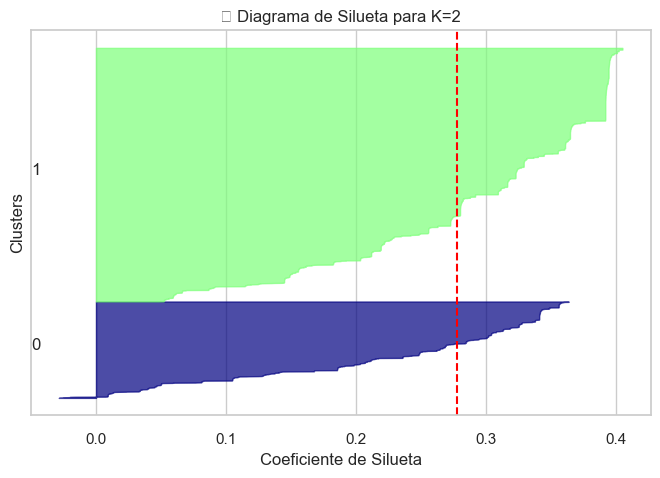

‚úÖ Para K=2, el score de silueta promedio es: 0.2777


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


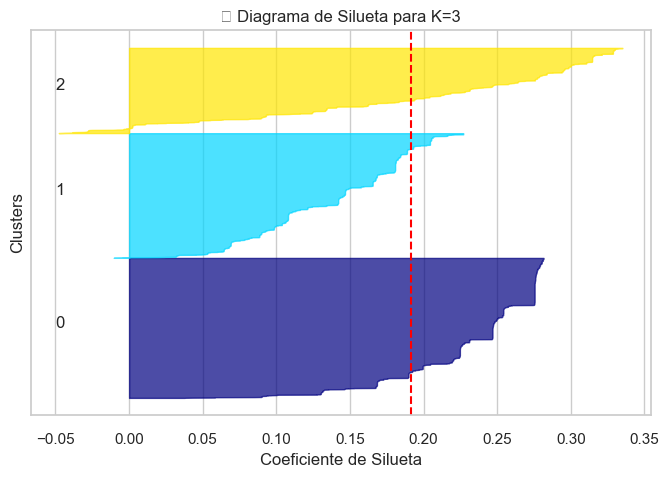

‚úÖ Para K=3, el score de silueta promedio es: 0.1916


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


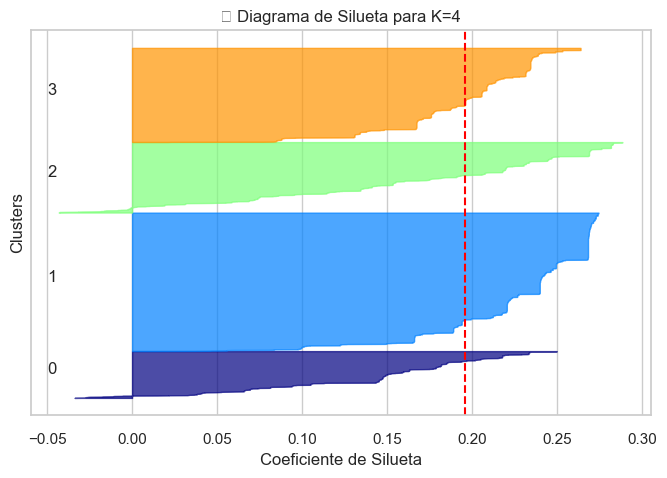

‚úÖ Para K=4, el score de silueta promedio es: 0.1956


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


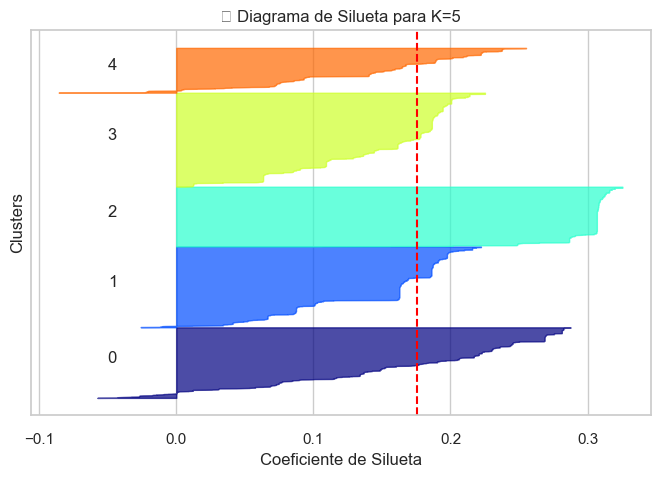

‚úÖ Para K=5, el score de silueta promedio es: 0.1756


In [50]:


# üîπ Definir valores de K a evaluar
k_values = [2, 3, 4, 5]

# üöÄ Iterar sobre cada K para generar el diagrama de silueta
for k in k_values:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # üìå Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_procesado)  # Dataset transformado y escalado
    
    # üìä Calcular los valores de silueta para cada punto
    silhouette_vals = silhouette_samples(X_procesado, cluster_labels)
    
    y_lower, y_upper = 0, 0  # L√≠mites de la visualizaci√≥n
    
    # üîç Dibujar cada cluster en la gr√°fica
    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        
        color = cm.jet(float(i) / k)  # Asignar colores
        
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + len(cluster_silhouette_vals) / 2, str(i))  # Etiquetas de cluster
        y_lower = y_upper
    
    # üìå Score de silueta general
    avg_silhouette = silhouette_score(X_procesado, cluster_labels)
    
    # üìä Ajustes del gr√°fico
    plt.axvline(avg_silhouette, color="red", linestyle="--")  # L√≠nea del score medio
    plt.title(f"üîç Diagrama de Silueta para K={k}")
    plt.xlabel("Coeficiente de Silueta")
    plt.ylabel("Clusters")
    plt.yticks([])
    plt.show()

    print(f"‚úÖ Para K={k}, el score de silueta promedio es: {avg_silhouette:.4f}")


### Ejercico 9:

En general, una diferencia entre el proceso de construcci√≥n de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperpar√°metros (como el n√∫mero de cl√∫steres) es anterior a la construcci√≥n del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

üìå Cantidad de elementos por cluster:
Cluster
0    1243
1    1107
2     757
Name: count, dtype: int64


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


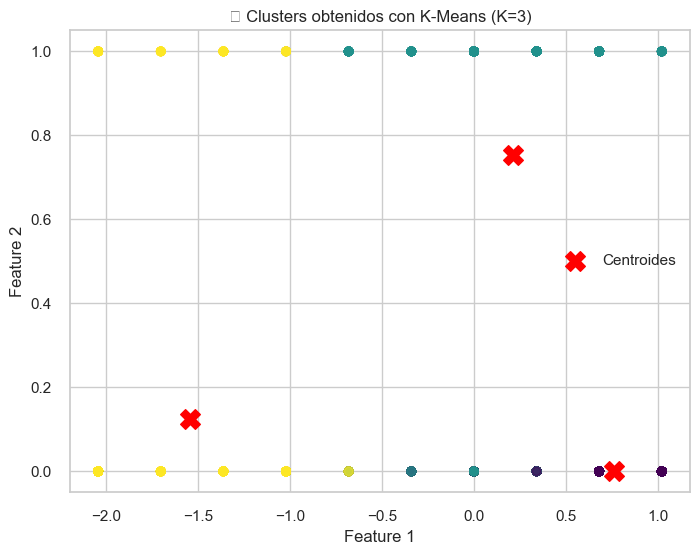

In [49]:


# üîπ Definir el mejor valor de K basado en el an√°lisis previo
k_optimo = 3  # üìå Cambia este valor seg√∫n tu an√°lisis

# üöÄ Instanciar y entrenar el modelo K-Means
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_filtrado["Cluster"] = kmeans.fit_predict(X_procesado)  # Asignar clusters al dataset

# üìå Cantidad de elementos por cluster
print("üìå Cantidad de elementos por cluster:")
print(df_filtrado["Cluster"].value_counts())

# üé® Visualizaci√≥n corregida
plt.figure(figsize=(8, 6))

# Asegurarnos de que X_procesado es un array numpy
if isinstance(X_procesado, pd.DataFrame):
    X_procesado = X_procesado.to_numpy()

plt.scatter(X_procesado[:, 0], X_procesado[:, 1], c=df_filtrado["Cluster"], cmap="viridis", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centroides")
plt.title(f"üîç Clusters obtenidos con K-Means (K={k_optimo})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribuci√≥n de cada uno de los cl√∫steres para el k √≥ptimo. Si tuvieras m√°s de un posible valor de k a probar, analiza aqu√≠ el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Adem√°s de hacer un describe de las features por cl√∫ster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el cl√∫ster como hue (color). Compara el resultado con los cl√∫steres sugeridos en el ejercicio 5.

In [48]:


# üìå Cargar el dataset (ajusta la ruta seg√∫n corresponda)
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path, sep="\t", encoding="utf-8")

# üîç Verificar si la columna "Cluster" existe
if "Cluster" in df.columns:
    print("‚úÖ La columna 'Cluster' ya est√° presente en el dataset.")
else:
    print("‚ö†Ô∏è La columna 'Cluster' no est√° en el dataset. Se proceder√° a asignar cl√∫steres.")


‚ö†Ô∏è La columna 'Cluster' no est√° en el dataset. Se proceder√° a asignar cl√∫steres.


In [30]:
print(df.dtypes)


Unnamed: 0            int64
urlDrugName          object
rating                int64
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object


In [31]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador
label_encoder = LabelEncoder()

# Convertir la columna categ√≥rica a valores num√©ricos
df["effectiveness_encoded"] = label_encoder.fit_transform(df["effectiveness"])

# Seleccionar solo las columnas num√©ricas para clustering
features = ["rating", "effectiveness_encoded"]  # Usamos la nueva columna num√©rica
X = df[features]


In [32]:
from sklearn.cluster import KMeans

# üîπ Aplicar K-Means con el n√∫mero √≥ptimo de clusters (ajusta si es necesario)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# üî• Guardar el dataset con los cl√∫steres asignados
df.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters.tsv", sep="\t", index=False)

print("‚úÖ Cl√∫steres asignados y dataset guardado correctamente.")


‚úÖ Cl√∫steres asignados y dataset guardado correctamente.


üìä Resumen estad√≠stico por cluster:
        Unnamed: 0                                                           \
             count         mean          std   min      25%     50%     75%   
Cluster                                                                       
0           2008.0  2042.674801  1186.350692   0.0  1033.75  2035.5  3060.5   
1            591.0  2196.744501  1193.802325  11.0  1160.50  2317.0  3164.0   
2            508.0  2095.431102  1180.962502   3.0  1118.50  2125.5  3177.5   

                 rating            ... sideEffects      effectiveness_encoded  \
            max   count      mean  ...         75%  max                 count   
Cluster                            ...                                          
0        4161.0  2008.0  8.815737  ...         1.0  3.0                2008.0   
1        4158.0   591.0  1.856176  ...         3.0  3.0                 591.0   
2        4160.0   508.0  5.844488  ...         2.0  3.0                 508.0   


C:\Users\hp\AppData\Local\Temp\ipykernel_12368\2200003040.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=df_clusters, palette="viridis")
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


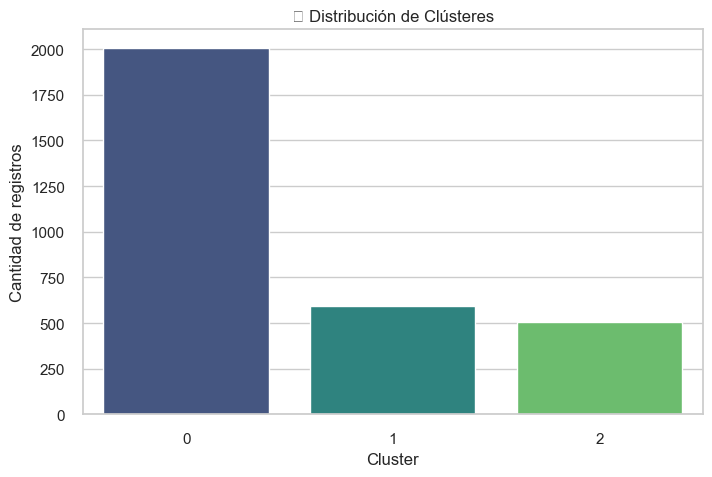

<Figure size 1200x600 with 0 Axes>

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


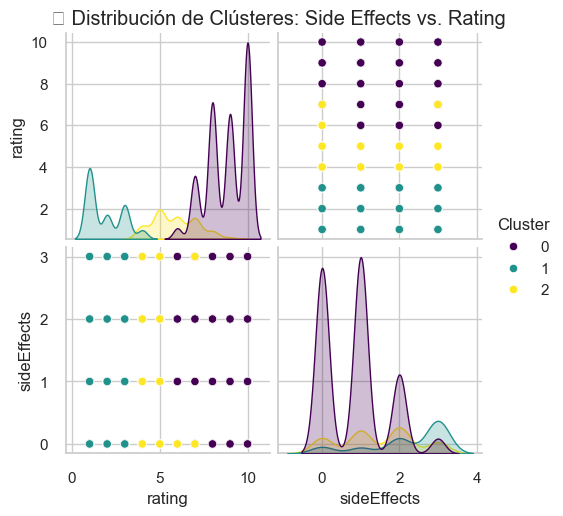

In [47]:

from sklearn.cluster import KMeans

# üìå Cargar el dataset con cl√∫steres asignados
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters.tsv"  # Ajusta la ruta si es necesario
df_clusters = pd.read_csv(file_path, sep="\t")

# üîπ Convertir 'rating' a num√©rico (si no lo es)
df_clusters["rating"] = pd.to_numeric(df_clusters["rating"], errors="coerce")

# üîπ Convertir 'sideEffects' a valores num√©ricos (ejemplo: asignar valores representativos)
side_effects_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3
}
df_clusters["sideEffects"] = df_clusters["sideEffects"].map(side_effects_mapping)

# üìä Resumen estad√≠stico por cl√∫ster
print("üìä Resumen estad√≠stico por cluster:")
cluster_summary = df_clusters.groupby("Cluster").describe()
print(cluster_summary)

# üìä Distribuci√≥n de cl√∫steres
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=df_clusters, palette="viridis")
plt.title("üìä Distribuci√≥n de Cl√∫steres")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de registros")
plt.show()

# üé® Pairplot corregido
plt.figure(figsize=(12, 6))
sns.pairplot(df_clusters, vars=["rating", "sideEffects"], hue="Cluster", palette="viridis")
plt.suptitle("üìä Distribuci√≥n de Cl√∫steres: Side Effects vs. Rating", y=1.02)

# üìå Mostrar el gr√°fico
plt.show()


### Ejercicio 11, EXTRA: M√°s valores de K

Repite el an√°lisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [44]:


# üìå Cargar el dataset original
file_path_original = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_raw.tsv"
df = pd.read_csv(file_path_original, sep="\t")

# üõë Eliminar columnas innecesarias
columnas_a_eliminar = ["Unnamed: 0", "urlDrugName"]  # Ajusta si es necesario
df = df.drop(columns=columnas_a_eliminar, errors="ignore")

# üöÄ Guardar el dataset limpio para futuros ejercicios
cleaned_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv"
df.to_csv(cleaned_path, sep="\t", index=False)

print(f"‚úÖ Dataset limpio guardado correctamente en: {cleaned_path}")



‚úÖ Dataset limpio guardado correctamente en: C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv


‚úÖ Cl√∫steres asignados con K=4 y dataset guardado correctamente.
üìä Resumen estad√≠stico por cluster:
         rating                                                 sideEffects  \
          count      mean       std  min  25%   50%   75%   max       count   
Cluster                                                                       
0         969.0  7.708978  0.583814  7.0  7.0   8.0   8.0   9.0       969.0   
1         391.0  1.915601  0.880290  1.0  1.0   2.0   3.0   3.0       391.0   
2        1154.0  9.640381  0.480097  9.0  9.0  10.0  10.0  10.0      1154.0   
3         418.0  5.119617  0.783553  4.0  4.0   5.0   6.0   6.0       418.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Cluster                                               
0        1.249742  0.841561  0.0  1.0  1.0  2.0  3.0  
1        2.235294  1.018235  0.0  2.0  3.0  3.0  3.0  
2        0.489601  0.583359  0.0  0.0  0.0  1.0  3.0  
3        1

C:\Users\hp\AppData\Local\Temp\ipykernel_12368\1511688623.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=df, palette="viridis")
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


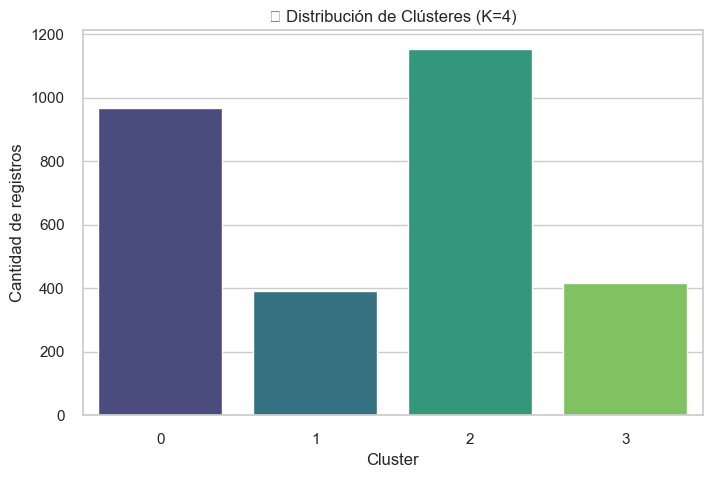

<Figure size 1200x600 with 0 Axes>

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


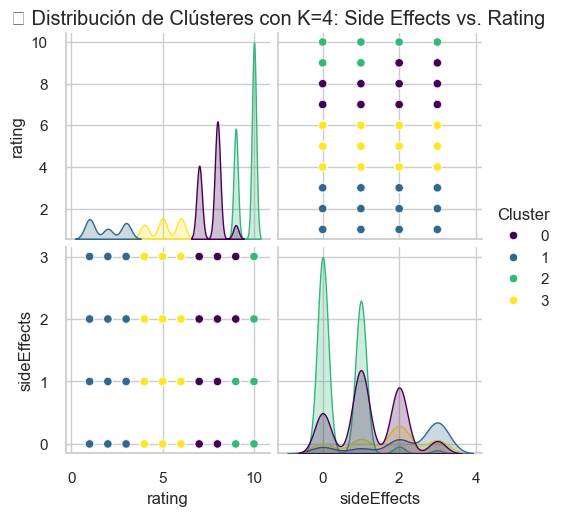

In [43]:


# üìå Cargar el dataset original sin cl√∫steres
file_path = r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_cleaned.tsv"
df = pd.read_csv(file_path, sep="\t")

# üîπ Convertir 'rating' a num√©rico (si no lo es)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# üîπ Convertir 'sideEffects' a valores num√©ricos
side_effects_mapping = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3
}
df["sideEffects"] = df["sideEffects"].map(side_effects_mapping)

# üîπ Seleccionar variables para clustering y eliminar nulos
features = ["rating", "sideEffects"]
df = df.dropna(subset=features)  # Eliminar filas con valores nulos en las columnas relevantes
X = df[features].reset_index(drop=True)  # Resetear √≠ndices para asegurar alineaci√≥n

# üìä Aplicar K-Means con un nuevo K (ajusta el valor seg√∫n el an√°lisis previo)
nuevo_K = 4  # Cambia este valor si lo consideras necesario
kmeans = KMeans(n_clusters=nuevo_K, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# üî• Guardar el dataset con el nuevo K
df.to_csv(r"C:\Users\hp\Desktop\Python Scripts\drugLibTrain_clusters_k4.tsv", sep="\t", index=False)
print(f"‚úÖ Cl√∫steres asignados con K={nuevo_K} y dataset guardado correctamente.")

# üìä Resumen estad√≠stico por cl√∫ster
print("üìä Resumen estad√≠stico por cluster:")
cluster_summary = df.groupby("Cluster").describe()
print(cluster_summary)

# üìä Distribuci√≥n de cl√∫steres
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=df, palette="viridis")
plt.title(f"üìä Distribuci√≥n de Cl√∫steres (K={nuevo_K})")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de registros")
plt.show()

# üé® Pairplot para visualizar relaci√≥n entre efectos secundarios y ratings con nuevo K
plt.figure(figsize=(12, 6))
sns.pairplot(df, vars=["rating", "sideEffects"], hue="Cluster", palette="viridis")
plt.suptitle(f"üìä Distribuci√≥n de Cl√∫steres con K={nuevo_K}: Side Effects vs. Rating", y=1.02)

# üìå Mostrar el gr√°fico
plt.show()
